In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
df= pd.read_csv('orders_analytics_full.csv')

In [ ]:
df


,order_id,customer_id,order_date,delivery_date,delivery_time_days,delivery_status,total_sales,AOV,order_frequency,monthly_order_growth_rate,is_churned
0,1,64,2021-08-30,2021-09-24,25,Late,1487.0,1487.0,1.0,-17.35,0
1,2,473,2021-02-03,2021-02-13,10,On-Time,1130.0,1130.0,1.0,-17.35,1
2,3,774,2021-10-08,2021-11-03,26,Late,508.0,508.0,1.0,-17.35,0
3,4,433,2021-05-06,2021-05-19,13,On-Time,976.0,976.0,1.0,-17.35,1
4,5,441,2021-03-23,2021-03-24,1,On-Time,2043.0,2043.0,2.0,-17.35,1
...,...,...,...,...,...,...,...,...,...,...,...
995,996,345,2021-01-13,2021-02-02,20,Late,1459.0,1459.0,1.0,-17.35,1
996,997,346,2021-01-18,2021-01-31,13,On-Time,204.0,204.0,1.0,-17.35,1
997,998,407,2021-05-05,2021-05-21,16,Late,1352.0,1352.0,1.0,-17.35,1
998,999,428,2021-06-15,2021-07-12,27,Late,440.0,440.0,1.0,-17.35,1


## Teslim Performansı Optimizasyonu (Classification)

In [ ]:
# Tarih tabanlı yeni sütunlar oluştur
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['month'] = df['order_date'].dt.month
df['day_of_week'] = df['order_date'].dt.dayofweek  # Pazartesi=0, Pazar=6

# Eksik değerleri tamamen düşür
df = df.dropna(subset=['AOV', 'total_sales', 'order_frequency', 'month', 'day_of_week', 'delivery_time_days'])


# Encode işlemi (On-Time → 1, Late → 0)
le = LabelEncoder()
df['delivery_status_encoded'] = le.fit_transform(df['delivery_status'])

# Özellik seti
X = df[['AOV', 'total_sales', 'order_frequency', 'month', 'day_of_week']]
y = df['delivery_status_encoded']

# Eğitim & test bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Ölçekleme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression modeli
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Tahmin ve metrikler
y_pred = model.predict(X_test_scaled)
print(" Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

#  Katsayılar
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

coefficients


 Accuracy: 0.507

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.33      0.39       142
           1       0.52      0.67      0.59       156

    accuracy                           0.51       298
   macro avg       0.50      0.50      0.49       298
weighted avg       0.50      0.51      0.49       298



/tmp/ipython-input-2599153797.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delivery_status_encoded'] = le.fit_transform(df['delivery_status'])


,Feature,Coefficient
2,order_frequency,0.011785
0,AOV,-0.004772
1,total_sales,-0.004772
4,day_of_week,-0.083213
3,month,-0.148563


## Değerlendirme

💬 Modelin doğruluk oranı (%50 civarı) tesadüfi tahmin seviyesinde
kaldı.

💬 Logistic Regression modeli, mevcut değişkenler (müşteri davranışı ve sipariş özellikleri) ile “On-Time vs Late” ayrımını başarılı şekilde öğrenemedi.

💬 "month" ve "day_of_week" gibi zaman temelli değişkenlerin oluşturulmasıyla oluşması tahmin edilen etki sınırlı kaldı (katsayılar küçük ve negatif).

💬 Model istatistiksel olarak anlamlı öngörü üretmedi.

Mevcut veri seti ve kullanılan değişkenlerle teslimat performansını tahmin etmeye yönelik Logistic Regression modeli anlamlı sonuç vermemiştir.
Teslimat durumunu etkileyen faktörlerin büyük olasılıkla operasyonel değişkenlerle ilişkili olduğu düşünülmektedir.

## Teslimat Tahminleme

In [ ]:
# Eksik verileri temizle
df = df.dropna(subset=['delivery_time_days', 'order_date'])

# Tarih bazlı değişkenleri ekle
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['month'] = df['order_date'].dt.month
df['day_of_week'] = df['order_date'].dt.dayofweek  # Pazartesi=0, Pazar=6

# Feature ve Target seçimi
X = df[['AOV', 'total_sales', 'order_frequency', 'month', 'day_of_week']]
y = df['delivery_time_days']

# Train-Test bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ölçekleme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model kurulumu
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Tahmin
y_pred = model.predict(X_test_scaled)

# Performans metrikleri
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f" MAE: {mae:.2f}")
print(f" RMSE: {rmse:.2f}")
print(f" R² Score: {r2:.3f}")


# Özelliklerin etkisi (katsayılar)
coeff = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

coeff


 MAE: 6.87
 RMSE: 7.93
 R² Score: -0.008


,Feature,Coefficient
3,month,0.490386
4,day_of_week,0.374765
0,AOV,0.104796
1,total_sales,0.104796
2,order_frequency,-0.088723


## Değerlendirme

💬 Teslimat süresi tahmini için kurulan Lineer Regresyon modeli, mevcut değişkenlerle anlamlı bir tahmin gücü sergilememiştir (R² ≈ 0).

💬 Model, teslimat süresindeki varyansı açıklayamamış, ortalama hata yaklaşık 7 gün olarak kalmıştır.

💬Bu durum, teslimat süresini etkileyen operasyonel faktörlerin  veri setinde yer almamasından kaynaklanıyor olabilir.

## Sipariş Trend Forecast

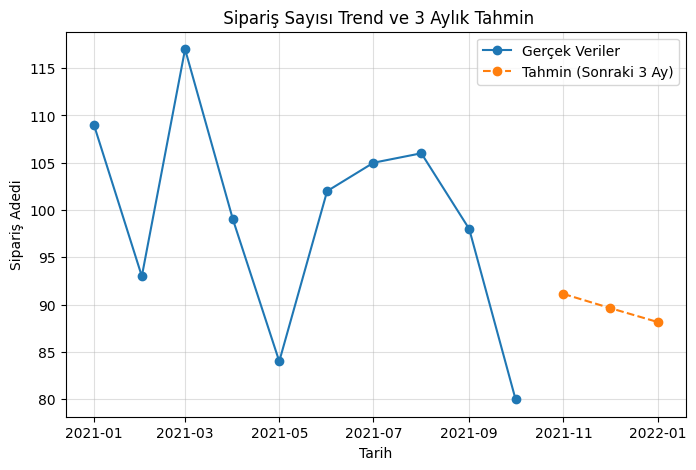

 Trend katsayısı: -1.48
 Sipariş sayısı azalan bir trend gösteriyor.


In [ ]:
# Tarih sütunu düzenleme
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df = df.dropna(subset=['order_date'])

# Aylık bazda sipariş sayısı
orders_monthly = (
    df.groupby(df['order_date'].dt.to_period('M'))['order_id']
    .count()
    .reset_index(name='order_count')
)

orders_monthly['order_date'] = orders_monthly['order_date'].dt.to_timestamp()
orders_monthly = orders_monthly.sort_values('order_date')

# Ay numarası ekle (model için)
orders_monthly['month_number'] = range(len(orders_monthly))

# Model (Lineer Regresyon)
X = orders_monthly[['month_number']]
y = orders_monthly['order_count']

model = LinearRegression()
model.fit(X, y)

# Gelecek 3 ayı tahmin et
future_months = pd.DataFrame({'month_number': range(len(orders_monthly), len(orders_monthly)+3)})
future_preds = model.predict(future_months)

future = pd.DataFrame({
    'order_date': pd.date_range(start=orders_monthly['order_date'].max() + pd.offsets.MonthBegin(1),
                                periods=3, freq='MS'),
    'predicted_orders': future_preds
})

# Görselleştirme
plt.figure(figsize=(8,5))
plt.plot(orders_monthly['order_date'], orders_monthly['order_count'], marker='o', label='Gerçek Veriler')
plt.plot(future['order_date'], future['predicted_orders'], marker='o', linestyle='--', label='Tahmin (Sonraki 3 Ay)')
plt.title(" Sipariş Sayısı Trend ve 3 Aylık Tahmin")
plt.xlabel("Tarih")
plt.ylabel("Sipariş Adedi")
plt.legend()
plt.grid(alpha=0.4)
plt.show()

# Trend katsayısı (artıyor mu, azalıyor mu?)
trend_coef = model.coef_[0]
print(f" Trend katsayısı: {trend_coef:.2f}")

if trend_coef > 0:
    print(" Sipariş sayısı artan bir trend gösteriyor.")
else:
    print(" Sipariş sayısı azalan bir trend gösteriyor.")


## Değerlendirme

💬 Sipariş sayısı trendi incelendiğinde, 2021 yılı itibariyle zayıf bir azalma eğilimi gözlemlenmiştir (β = -1.48).

💬 Lineer tahmin modeli, önümüzdeki 3 aylık dönemde sipariş hacminde sınırlı bir düşüş öngörmektedir.

💬 Bu durum, mevsimsel etkiler veya azalan müşteri etkileşimi ile ilişkili olabilir.

## Facebook Prophet ile Zaman Serisi Tahmini

In [ ]:
!pip install prophet --upgrade --no-cache-dir --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 148.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 233.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 139.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 165.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 204.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 180.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 132.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 147.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 186.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Prophet için veri formatı hazırlığı
from prophet import Prophet
import pandas as pd

df = pd.read_csv('orders_analytics_full.csv') # Re-load df to ensure it's defined

df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
orders_monthly = (
    df.groupby(df['order_date'].dt.to_period('M'))['order_id']
    .count()
    .reset_index(name='order_count')
)
orders_monthly['ds'] = orders_monthly['order_date'].dt.to_timestamp()
orders_monthly['y'] = orders_monthly['order_count']

orders_monthly = orders_monthly[['ds', 'y']]
orders_monthly.head()

,ds,y
0,2021-01-01,109
1,2021-02-01,94
2,2021-03-01,118
3,2021-04-01,101
4,2021-05-01,84


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


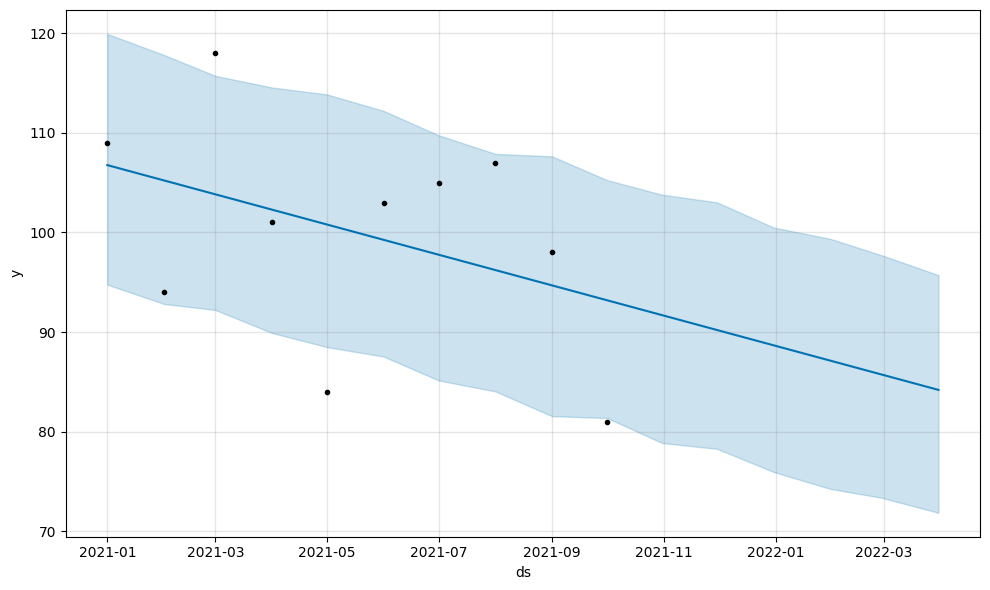

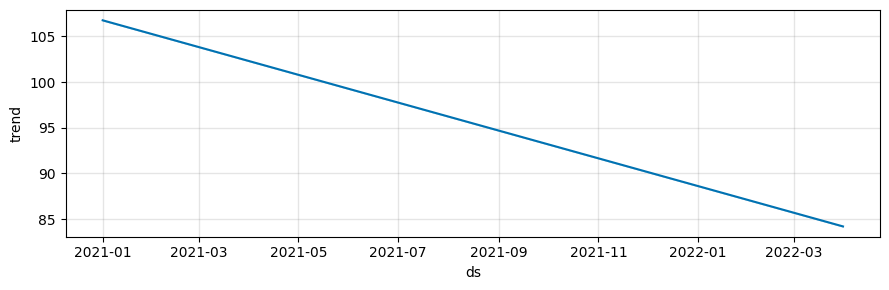

In [ ]:
# Prophet için veri formatı hazırlığı
import pandas as pd
from prophet import Prophet

df = pd.read_csv('orders_analytics_full.csv') # Re-load df to ensure it's defined

df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
orders_monthly = (
    df.groupby(df['order_date'].dt.to_period('M'))['order_id']
    .count()
    .reset_index(name='order_count')
)
orders_monthly['ds'] = orders_monthly['order_date'].dt.to_timestamp()
orders_monthly['y'] = orders_monthly['order_count']

orders_monthly = orders_monthly[['ds', 'y']]

# Prophet model oluşturma
m = Prophet()

# Veriyi modele öğret
m.fit(orders_monthly)

# Gelecek 6 ay için tahmin yap
future = m.make_future_dataframe(periods=6, freq='M')

forecast = m.predict(future)

# Tahmin grafiği
fig1 = m.plot(forecast)

fig2 = m.plot_components(forecast)


## Değerlendirme

💬 Prophet zaman serisi modeli, geçmiş sipariş verilerini analiz ederek 2021–2022 dönemi boyunca sipariş hacminde düşen bir trend tespit etmiştir.

💬 Model, 6 aylık ileri tahminde sipariş sayısının ortalama 105’ten 85’e gerileyeceğini öngörmektedir.

💬 Bu eğilim, operasyonel veya talep yönlü azalma ile ilişkilendirilebilir.